In [25]:
import os

data_dir = os.path.join(os.getenv("HOME"), "OCR/data")  # Construct the path to the data directory
os.chdir(data_dir)  # Change working directory to data_dir

print(data_dir)

D:\project\Aiffel\OCR/data


In [26]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [27]:
pip install lmdb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import re
import six
import math
import lmdb
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

TRAIN_DATA_PATH = data_dir + '/MJ/MJ_train'
VALID_DATA_PATH = data_dir + '/MJ/MJ_valid'
TEST_DATA_PATH  = data_dir + '/MJ/MJ_test'

# data\data_lmdb_release\data_lmdb_release\data_lmdb_release\training\MJ\MJ_train
# 다운 받은 data_lmdb_release
print(TRAIN_DATA_PATH)

Using device: cuda
D:\project\Aiffel\OCR/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


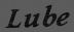

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


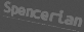

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


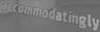

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


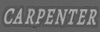

In [29]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [30]:
class MJDataset(Dataset):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(
        self,
        dataset_path,
        label_converter,
        img_size=(100, 32),
        max_text_len=22,
        character="",
    ):
        super().__init__()
        self.label_converter = label_converter
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character

        # lmdb open
        self.env = lmdb.open(dataset_path,max_readers=32,readonly=True,lock=False,readahead=False,meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get("num-samples".encode()))
            self.index_list = [idx + 1 for idx in range(self.num_samples)]

    def __len__(self):
        return self.num_samples

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def __getitem__(self, idx):
        index = self.index_list[idx]
        with self.env.begin(write=False) as txn:
            label_key = f"label-{index:09d}".encode()
            label = txn.get(label_key).decode("utf-8")

            img_key = f"image-{index:09d}".encode()
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)

            try:
                img_pil = Image.open(buf).convert("RGB")
            except IOError:
                img_pil = Image.new("RGB", self.img_size)
                label = "-"

        orig_w, orig_h = img_pil.size
        target_width = min(int(orig_w * self.img_size[1] / orig_h), self.img_size[0])
        target_img_size = (target_width, self.img_size[1])
        img_pil = img_pil.resize(target_img_size)

        img = np.array(img_pil)
        img = img.transpose(2, 0, 1)

        padded_img = np.zeros((3, self.img_size[1], self.img_size[0]), dtype=np.float32)
        c, h, w = img.shape
        padded_img[:, :h, :w] = img

        # 레이블 전처리
        label = label.upper()
        out_of_char = f"[^{self.character}]"
        label = re.sub(out_of_char, "", label)
        label = label[: self.max_text_len]

        encoded_label = self.label_converter.encode(label)

        return padded_img, encoded_label, len(encoded_label), label

In [31]:
def collate_fn(batch):
    imgs, encoded_labels, label_lens, raw_labels = zip(*batch)

    imgs_tensor = torch.tensor(np.stack(imgs, axis=0), dtype=torch.float32)

    max_len = max(label_lens)
    labels_padded = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, label_arr in enumerate(encoded_labels):
        length = label_lens[i]
        labels_padded[i, :length] = torch.tensor(label_arr, dtype=torch.long)

    batch_size = imgs_tensor.size(0)
    # 여기서는 크기 24로 가정
    input_length = torch.full(size=(batch_size,), fill_value=24, dtype=torch.long)
    label_length = torch.tensor(label_lens, dtype=torch.long)

    return (
        imgs_tensor,
        labels_padded,
        input_length,
        label_length,
        raw_labels,  # 디버깅용
    )

In [32]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label, dtype=np.int32)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [33]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [34]:
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

print("슝~")

슝~


In [35]:
class CRNN(nn.Module):
    def __init__(self, num_chars, img_height=32, img_width=100):
        super(CRNN, self).__init__()
        # num_chars: 실제 문자 개수(+2) -> 여기서는 +2(CTC Blank 등)를
        # LabelConverter에서 이미 blank를 붙여줬으니,
        # 파이토치의 CTCLoss는 blank 인덱스를 지정 가능하므로, +2 없이 설계할 수 있음.
        # 여기서는 blank를 0번으로 하므로 굳이 +2가 필요 없을 수 있습니다.
        # 필요시엔 +1 혹은 +2로 조정하세요.
        self.num_chars = num_chars

        # (3, H, W) -> (64, H, W)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (64, H/2, W/2)

        # (64, H/2, W/2) -> (128, H/2, W/2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128, H/4, W/4)

        # (128, H/4, W/4) -> (256, H/4, W/4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((1, 2))  # (256, H/4, W/8)

        # (256, H/4, W/8) -> (512, H/4, W/8)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d((1, 2))  # (512, H/4, W/16)

        # (512, H/4, W/16) -> (512, (H/4)-1, (W/16)-1) conv(2,2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=(2, 2))
        # 최종 (512, (H/4)-1, (W/16)-1)
        # 예) H=32 -> H/4=8 -> (8)-1=7
        #     W=100 -> W/16=6.25 -> 실제 integer shape는 계산 필요
        # 텐서플로우 예시에선 (24, 512) 시퀀스로 reshape했으니, 여기선 실제 연산으로 확인 필요

        # Bi-LSTM
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)

        # 최종 fc
        self.fc = nn.Linear(512, self.num_chars)

    def forward(self, x):
        # (B,3,32,100)
        x = F.relu(self.conv1(x))      # -> (B,64,32,100)
        x = self.pool1(x)             # -> (B,64,16,50)
        x = F.relu(self.conv2(x))      # -> (B,128,16,50)
        x = self.pool2(x)             # -> (B,128,8,25)
        x = F.relu(self.conv3(x))      # -> (B,256,8,25)
        x = F.relu(self.conv4(x))      # -> (B,256,8,25)
        x = self.pool3(x)             # -> (B,256,8,12) (25->12)
        x = F.relu(self.conv5(x))      # -> (B,512,8,12)
        x = self.bn5(x)
        x = F.relu(self.conv6(x))      # -> (B,512,8,12)
        x = self.bn6(x)
        x = self.pool4(x)             # -> (B,512,8,6)
        x = F.relu(self.conv7(x))      # -> (B,512,7,5) (8->7, 6->5)

        b, c, h, w = x.size()
        # 시퀀스 길이 = h*w
        x = x.view(b, c, h * w)  # (B,512,35)
        x = x.permute(0, 2, 1)   # (B,35,512)

        # LSTM
        x, _ = self.lstm1(x)    # (B,35,512)
        x, _ = self.lstm2(x)    # (B,35,512)

        # 최종 FC
        x = self.fc(x)          # (B,35,num_chars)

        # PyTorch의 CTCLoss를 위해선 (T,B,C) 형태가 일반적
        # 여기서는 (B,T,C) -> (T,B,C)
        x = x.permute(1, 0, 2)  # (35,B,num_chars)
        return x

In [ ]:
MAX_TEXT_LEN = 22
IMG_SIZE = (100, 32)
BATCH_SIZE = 128

train_dataset = MJDataset(TRAIN_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
valid_dataset = MJDataset(VALID_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)

# 아래 문제 발생으로 변경
# train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,collate_fn=collate_fn,drop_last=False)
# valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_fn,drop_last=False)
# test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_fn,drop_last=False)
# 마지막 배치는 생략합니다.
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=0,collate_fn=collate_fn,drop_last=False)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)

문제 발생
  TypeError: cannot pickle 'Environment' object

  문제 원인:
  이 에러는 PyTorch의 DataLoader가 데이터를 병렬로 로딩하기 위해 여러 개의 프로세스(num_workers > 0)를
  사용할 때 발생합니다. MJDataset 클래스 내에서 사용하는 lmdb 데이터베이스 환경 객체(self.env)는 다른
  프로세스로 전달될 수 없는(pickle이 불가능한) 형태입니다. 따라서 DataLoader가 이 객체를 서브 프로세스로
  복사하려고 할 때 타입 에러가 발생합니다. 이는 특히 Windows 환경에서 흔히 발생하는 문제입니다

  해결 방안:
  가장 간단한 해결 방법은 DataLoader의 num_workers 옵션을 0으로 설정하여 멀티프로세싱을 사용하지 않고 메인
  프로세스에서만 데이터를 로드하도록 변경하는 것입니다.

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)

model = CRNN(num_chars=num_chars).to(device)

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
optimizer = optim.Adadelta(model.parameters(), lr=0.1)

In [42]:
def run_training(
        train_loader,
        valid_loader,
        model,
        optimizer,
        criterion,
        patience=2,
        epochs=1,
        checkpoint_path="~/work/ocr/model_checkpoint.pth"
        ):

    best_val_loss = float('inf')
    patience_counter = 0
    batch_limit = 500

    print("학습시작!...")

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(train_loader):
            if idx == batch_limit:
                break
            imgs = imgs.to(device)
            labels_padded = labels_padded.to(device)
            input_lengths = input_lengths.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)  # (T,B,C)

            # CTCLoss는 입력 (T,B,C), 타겟 (B,S), input_length, target_length
            loss = criterion(outputs, labels_padded, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(valid_loader):
                if idx == batch_limit:
                    break
                imgs = imgs.to(device)
                labels_padded = labels_padded.to(device)
                input_lengths = input_lengths.to(device)
                label_lengths = label_lengths.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels_padded, input_lengths, label_lengths)
                valid_loss += loss.item()


        print(f"[Epoch {epoch}/{epochs}] train_loss={train_loss/len(train_loader):.4f}, val_loss={valid_loss/len(valid_loader):.4f}")

        # 체크포인트 저장
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model improved. Saved at {checkpoint_path}")
        else:
            patience_counter += 1

        # EarlyStopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return model

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [46]:
%%time

model = run_training(
    train_loader,
    valid_loader,
    model,
    optimizer,
    criterion,
    patience=2,
    epochs=10,
    checkpoint_path="model_checkpoint.pth"
    )

학습시작!...
[Epoch 1/10] train_loss=0.0251, val_loss=0.2445
Model improved. Saved at model_checkpoint.pth
[Epoch 2/10] train_loss=0.0238, val_loss=0.2320
Model improved. Saved at model_checkpoint.pth
[Epoch 3/10] train_loss=0.0218, val_loss=0.2162
Model improved. Saved at model_checkpoint.pth
[Epoch 4/10] train_loss=0.0189, val_loss=0.1410
Model improved. Saved at model_checkpoint.pth
[Epoch 5/10] train_loss=0.0152, val_loss=0.1018
Model improved. Saved at model_checkpoint.pth
[Epoch 6/10] train_loss=0.0119, val_loss=0.0912
Model improved. Saved at model_checkpoint.pth
[Epoch 7/10] train_loss=0.0099, val_loss=0.1062
[Epoch 8/10] train_loss=0.0084, val_loss=0.1035
Early stopping triggered.
CPU times: total: 1h 38min 52s
Wall time: 12min 47s


In [47]:
def decode_greedy(output, label_converter):
    # (T,B,C) -> (B,T) index
    out = output.detach().cpu().numpy()  # (T,B,C)
    argmax = out.argmax(axis=2).transpose()  # (B,T)

    results = []
    for seq in argmax:
        # 연속된 동일 글자(또는 blank=0) 제거 로직을 적용해야
        # CTC 디코딩다운 결과가 나옵니다.
        # 여기서는 간단히 blank(0) 무시하고 연속 제거만 보여줌
        decoded = []
        prev = None
        for idx in seq:
            if idx != 0 and idx != prev:
                decoded.append(idx)
            prev = idx
        # 인덱스를 실제 문자로
        decoded_str = label_converter.decode(decoded).replace('-', '')
        results.append(decoded_str)
    return results

In [48]:
def check_inference(model, dataset, index=5):
    for i in range(index):
        img, encoded_label, label_len, raw_label = dataset[i]  # 단일 데이터
        img_tensor = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).to(device)  # (1,3,32,100)
        output = model(img_tensor)  # (T,1,num_chars)
        # 디코딩
        result_text = decode_greedy(output, label_converter)[0]
        print(f"GT: {raw_label} / Pred: {result_text}")

        # 이미지를 시각화하고 싶으면
        display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))

GT: SLINKING / Pred: SLNNKINGSG


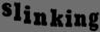

GT: REMODELERS / Pred: RENDIAS


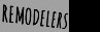

GT: CHRONOGRAPHS / Pred: CUASOPPARS


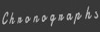

GT: IMPEACHING / Pred: INPPEACHING


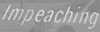

GT: DISCOMBOBULATED / Pred: INANTILAEDSD


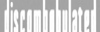

GT: LOOTS / Pred: LOOTS


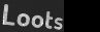

GT: UNDERPAYS / Pred: UNDERPAYSY


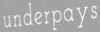

GT: FLAMEPROOFED / Pred: BUNAES


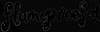

GT: ENTICEMENTS / Pred: LENTICEMENS


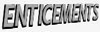

GT: UKASE / Pred: UASEE


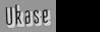

In [49]:
check_inference(model, test_dataset, index=10)

# 프로젝트:End-to-End OCR

In [50]:
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2

print("NumPy:", np.__version__)
print("PIL:", Image.__version__)
print("OpenCV:", cv2.__version__)

NumPy: 2.2.6
PIL: 11.3.0
OpenCV: 4.12.0


In [62]:
#  easy-ocr을 설치
!pip install easyocr



  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl.metadata (14 kB)
  Using cached ninja-1.13.0-py3-none-win_amd64.whl.metadata (5.1 kB)
  Using cached imageio-2.37.0-py3-none-any.whl.metadata (5.2 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)
Using cached ninja-1.13.0-py3-none-win_amd64.whl (309 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)
Using cached scikit_image-0.25.2-cp313-cp313-win_amd64.whl (12.9 MB)
Using cached imageio-2.37.0-py3-none-any.whl (315 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)

   ---------------------------------------- 0/6 [opencv-python-headless]



ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\kicha\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
# `sample.jpg` 다운로드
# wget ~/data https://d3s0tskafalll9.cloudfront.net/media/original_images/sample.jpg

!curl -o D:\project\Aiffel\OCR\data\sample.jpg https://d3s0tskafalll9.cloudfront.net/media/original_images/sample.jpg


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 98665  100 98665    0     0   312k      0 --:--:-- --:--:-- --:--:--  314k


In [60]:
!dir

 Volume in drive D is D DRIVER
 Volume Serial Number is A222-DFC2

 Directory of D:\project\Aiffel\OCR\data

2025-09-11  오전 12:21    <DIR>          .
2025-09-10  오후 02:59    <DIR>          ..
2025-09-10  오후 03:36    <DIR>          data_lmdb_release
2025-09-10  오후 03:27    23,344,948,659 data_lmdb_release.zip
2025-09-10  오후 03:43    <DIR>          MJ
2025-09-11  오전 12:04        34,919,297 model_checkpoint.pth
2025-09-11  오전 12:21            98,665 sample.jpg
               3 File(s) 23,379,966,621 bytes
               4 Dir(s)  1,784,313,778,176 bytes free


In [64]:
import easyocr

print("EasyOCR:", easyocr.__version__)

HOME_DIR = "/content"

# EasyOCR Reader 생성 (필요한 언어 설정, 예: 영어)
reader = easyocr.Reader(['en'])

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

EasyOCR: 1.7.2
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [65]:
def detect_text(img_path):
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    # EasyOCR은 numpy 배열을 입력받으므로 변환
    img_np = np.array(img_pil)

    # EasyOCR을 이용한 텍스트 검출 및 인식
    # 결과 형식: [(bbox, text, confidence), ...]
    ocr_result = reader.readtext(img_np)

    # 시각화를 위해 ImageDraw 객체 생성
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []

    for bbox, text, conf in ocr_result:
        # 좌표를 정수형으로 변환
        bbox_int = [(int(x), int(y)) for x, y in bbox]
        img_draw.polygon(bbox_int, outline='red')

        xs = [pt[0] for pt in bbox_int]
        ys = [pt[1] for pt in bbox_int]
        x_min = max(0, min(xs) - 5)
        y_min = max(0, min(ys) - 5)
        x_max = max(xs) + 5
        y_max = max(ys) + 5
        word_box = (x_min, y_min, x_max, y_max)
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs, ocr_result

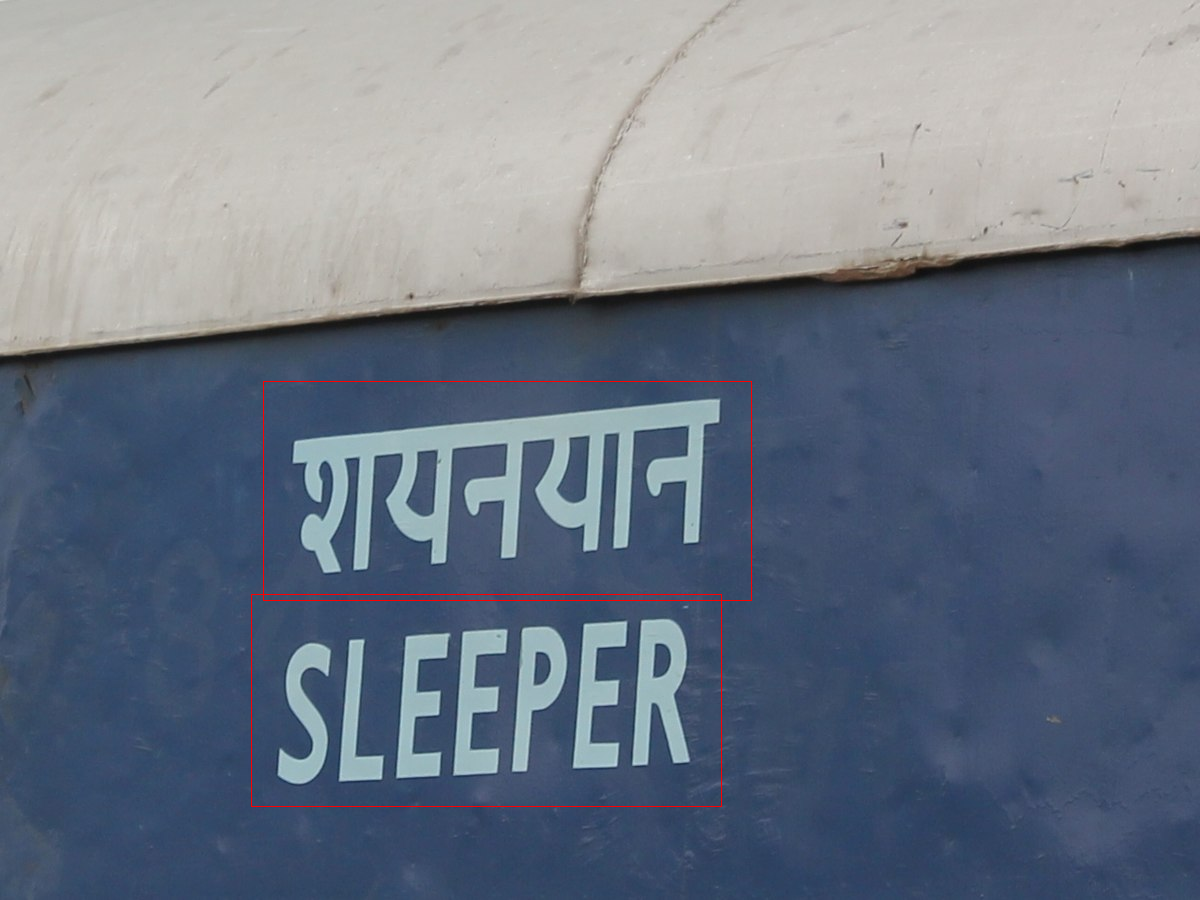

In [68]:
SAMPLE_IMG_PATH = 'D:/project/Aiffel/OCR/data/sample.jpg'
img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
img_pil

In [69]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!

    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(pil_img)
    # 인식 모델 입력 크기에 맞게 이미지 크기 조정
    img_resized = cv2.resize(img_np, input_img_size)

    # detail=0 옵션은 인식 결과의 텍스트만 반환합니다.
    result = reader.readtext(img_resized, detail=0, paragraph=False)

    if result:
        recognized_text = result[0]
    else:
        recognized_text = ""

    print("Recognized text:", recognized_text)
    return recognized_text

In [70]:
for idx, word_img in enumerate(cropped_imgs):
    print(f"[{idx}] ", end="")
    recognize_img(word_img)

[0] Recognized text: PI4741T
[1] Recognized text: SLEEPER
